# Import Statements



In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import seaborn as sns

from io import StringIO
import sys

import sklearn
import sklearn.linear_model as sl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Data Pre-processing

### Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/nevada_weather.csv")

In [6]:
# Dropping Year Column
df.drop("Year",axis=1, inplace=True)

In [7]:
# Mapping isDay (false/true) -> (0/1)
df.replace(to_replace=True, value=1, inplace=True)
df.replace(to_replace=False, value=0, inplace=True)

In [8]:
# Max-Min Normalisation
# for column in df:
#   if(column!="GHI"):
#     df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [9]:
# Dropping columns
df = df.drop(["DHI", "Clearsky DHI", "Clearsky DNI", "Clearsky GHI", "DNI", "Fill Flag", "Dew Point"], axis = 1)

# Model Spilting

In [10]:
# Mapping the data
total_records = len(df)
features = df[:total_records-288].drop('GHI', axis=1).reset_index()
output = df['GHI'][288:].reset_index()
df = pd.concat([features, output], join='inner', axis=1)
df.drop(['index'], axis=1, inplace=True)

In [11]:
df_day = df[df.is_day == 1].drop('is_day', axis=1)
df_night = df[df.is_day == 0].drop('is_day', axis=1)

In [12]:
df_day.shape

(26674, 15)

In [13]:
def feature_output_split(x):
  total_records = len(x)
  features = x.drop('GHI', axis=1)
  output = x['GHI']

  return features, output

In [14]:
feature_df, GHI = feature_output_split(df)
day_feature_df, day_GHI = feature_output_split(df_day)
night_feature_df, night_GHI = feature_output_split(df_night)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(feature_df, GHI, test_size=.20, random_state=42)
day_x_train, day_x_test, day_y_train, day_y_test = train_test_split(day_feature_df, day_GHI, test_size=.20, random_state=42)
night_x_train, night_x_test, night_y_train, night_y_test = train_test_split(night_feature_df, night_GHI, test_size=.20, random_state=42)

# Linear Regression

In [16]:
def apply_LR(x_train, y_train, x_test, y_test):
  linear = LinearRegression()
  linear.fit(x_train, y_train)

  y_train_pred = linear.predict(x_train)
  train_rmse = metrics.mean_squared_error(y_train, y_train_pred) ** 0.5
  print("Train RMSE: ", train_rmse)
  y_test_pred = linear.predict(x_test)
  test_rmse = metrics.mean_squared_error(y_test, y_test_pred) ** 0.5
  print("Test RMSE: ", test_rmse)

In [17]:
# whole data
apply_LR(x_train, y_train, x_test, y_test)

Train RMSE:  151.55383564616952
Test RMSE:  152.01901309262257


In [18]:
# day_time_data
apply_LR(day_x_train, day_y_train, day_x_test, day_y_test)

Train RMSE:  113.40550303779567
Test RMSE:  114.88453421034431


In [19]:
# night_time_data
apply_LR(night_x_train, night_y_train, night_x_test, night_y_test)

Train RMSE:  6.392624176593561
Test RMSE:  6.225040022294496


In [20]:
def combine_result(y1, y1_pred, y2, y2_pred):
  combined_y_pred = np.concatenate([y1_pred, y2_pred])
  combined_y = np.concatenate([y1, y2])
  rmse = metrics.mean_squared_error(combined_y, combined_y_pred) ** 0.5
  return rmse

In [21]:
# combining day and night time results
day_linear = LinearRegression()
day_linear.fit(day_x_train, day_y_train)
night_linear = LinearRegression()
night_linear.fit(night_x_train, night_y_train)

day_y_train_pred = day_linear.predict(day_x_train)
night_y_train_pred = night_linear.predict(night_x_train)
train_rmse = combine_result(day_y_train, day_y_train_pred, night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

day_y_test_pred = day_linear.predict(day_x_test)
night_y_test_pred = night_linear.predict(night_x_test)
test_rmse = combine_result(day_y_test, day_y_test_pred, night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Train RMSE:  81.13455703527238
Test RMSE:  82.18219926974604


# Lasso Regression

In [22]:
def apply_Lasso(x_train, y_train, x_test, y_test):
  lasso_alpha_vec = np.arange(1e-3,3,0.1)
  lasso_train_rmse = []
  lasso_test_rmse = []

  for alpha in lasso_alpha_vec:
    lasso = Lasso(alpha)
    lasso.fit(x_train, y_train)

    y_train_pred = lasso.predict(x_train)
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred) ** 0.5
    lasso_train_rmse.append(train_rmse)

    y_test_pred = lasso.predict(x_test)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred) ** 0.5
    lasso_test_rmse.append(test_rmse)  

  plt.figure(figsize=(30,10))
  plt.plot(list(map(str, lasso_alpha_vec)), lasso_train_rmse, color='r')
  plt.plot(list(map(str, lasso_alpha_vec)), lasso_test_rmse, color='y')
  plt.title("Lasso: Training/Testing rmse with alpha")
  plt.xlabel("alpha")
  plt.ylabel("rmse")
  plt.show()

  lasso_optimal_train_rmse = min(lasso_train_rmse)
  optimal_i = lasso_train_rmse.index(lasso_optimal_train_rmse)
  lasso_optimal_train_alpha = lasso_alpha_vec[optimal_i]
  print("Optimal train alpha value: ", lasso_optimal_train_alpha)
  print("Optimal train rmse: ", lasso_optimal_train_rmse)

  lasso_optimal_test_rmse = min(lasso_test_rmse)
  optimal_i = lasso_test_rmse.index(lasso_optimal_test_rmse)
  lasso_optimal_test_alpha = lasso_alpha_vec[optimal_i]
  print("Optimal test alpha value: ", lasso_optimal_test_alpha)
  print("Optimal test rmse: ", lasso_optimal_test_rmse)

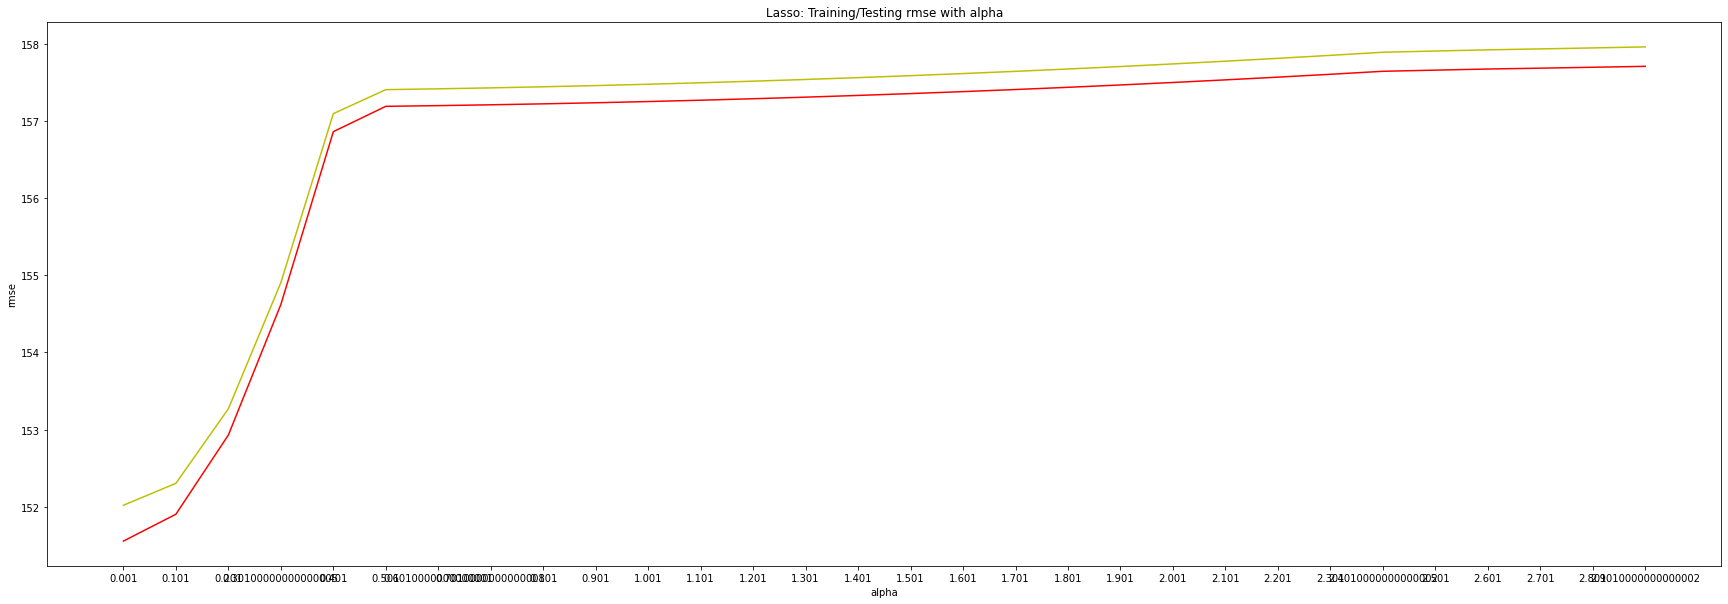

Optimal train alpha value:  0.001
Optimal train rmse:  151.55386989094632
Optimal test alpha value:  0.001
Optimal test rmse:  152.01837679456074


In [23]:
# whole data
apply_Lasso(x_train, y_train, x_test, y_test)

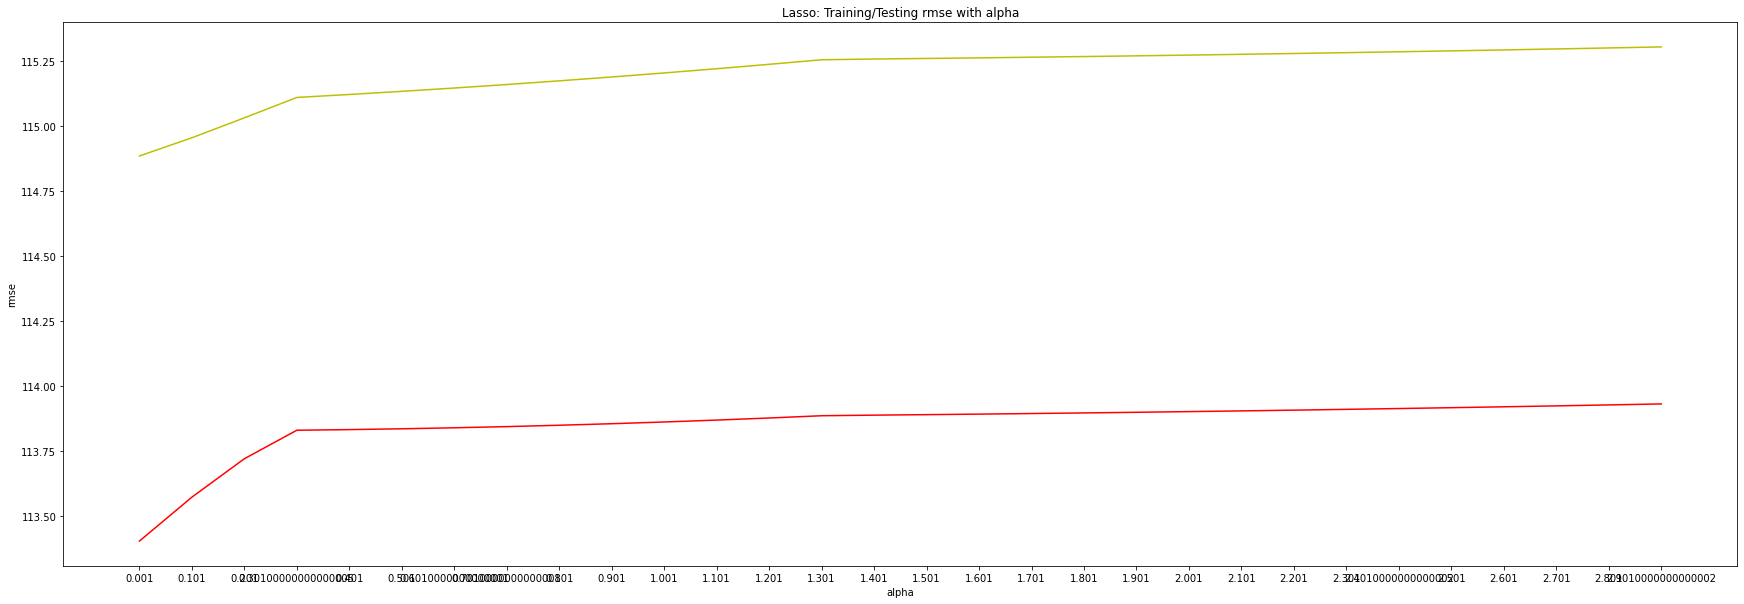

Optimal train alpha value:  0.001
Optimal train rmse:  113.40552841336489
Optimal test alpha value:  0.001
Optimal test rmse:  114.88355845440145


In [24]:
# day_time_data
apply_Lasso(day_x_train, day_y_train, day_x_test, day_y_test)

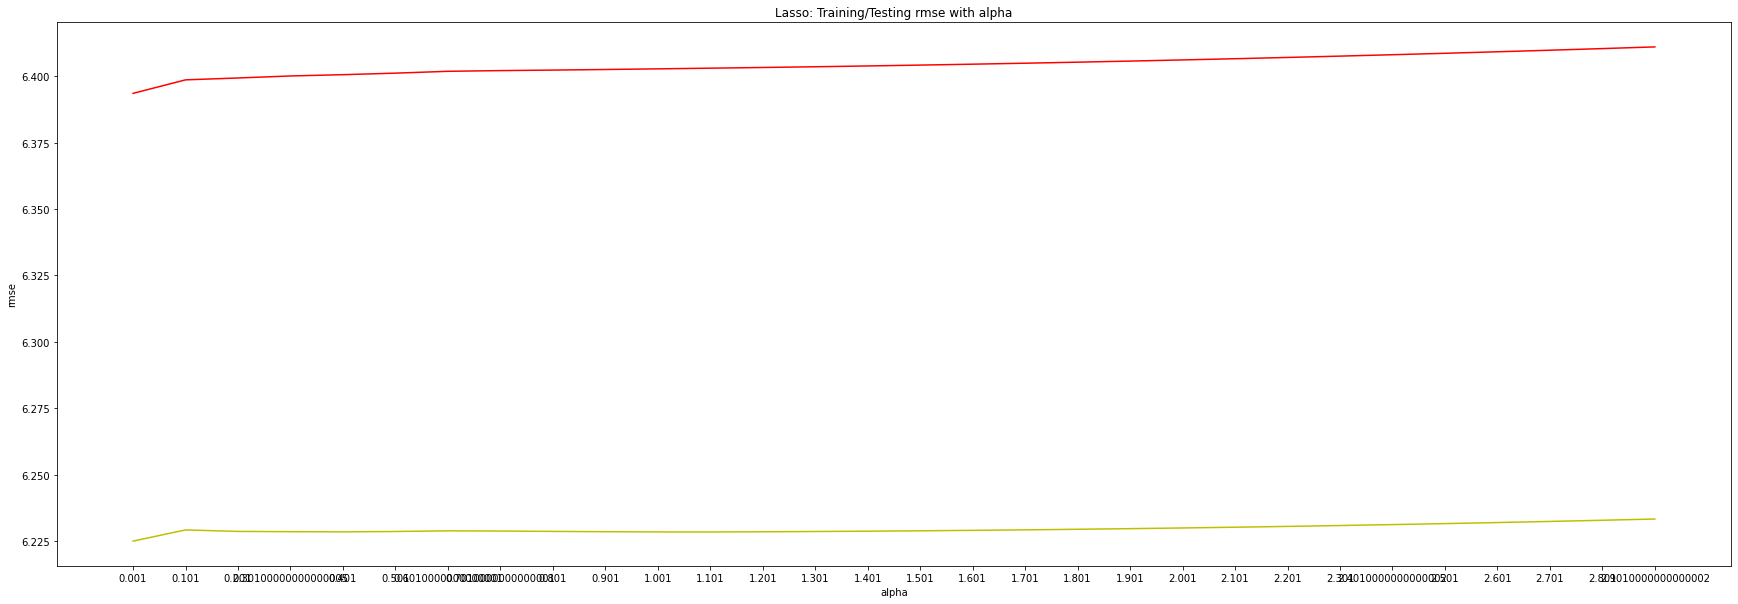

Optimal train alpha value:  0.001
Optimal train rmse:  6.393545687742567
Optimal test alpha value:  0.001
Optimal test rmse:  6.224946036999009


In [25]:
# night_time_data
apply_Lasso(night_x_train, night_y_train, night_x_test, night_y_test)

In [26]:
# combining day and night time results
day_lasso = Lasso(0.001)
day_lasso.fit(day_x_train, day_y_train)
night_lasso = Lasso(0.001)
night_lasso.fit(night_x_train, night_y_train)

day_y_train_pred = day_lasso.predict(day_x_train)
night_y_train_pred = night_lasso.predict(night_x_train)
train_rmse = combine_result(day_y_train, day_y_train_pred, night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

day_y_test_pred = day_lasso.predict(day_x_test)
night_y_test_pred = night_lasso.predict(night_x_test)
test_rmse = combine_result(day_y_test, day_y_test_pred, night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Train RMSE:  81.13461069290894
Test RMSE:  82.18149974148092


# Ridge Regression

In [27]:
def apply_Ridge(x_train, y_train, x_test, y_test):
  ridge_alpha_vec = np.arange(1e-3,3,0.1)
  ridge_train_rmse = []
  ridge_test_rmse = []

  for alpha in ridge_alpha_vec:
    ridge = Ridge(alpha)
    ridge.fit(x_train, y_train)

    y_train_pred = ridge.predict(x_train)
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred) ** 0.5
    ridge_train_rmse.append(train_rmse)

    y_test_pred = ridge.predict(x_test)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred) ** 0.5
    ridge_test_rmse.append(test_rmse)  

  plt.figure(figsize=(30,10))
  plt.plot(list(map(str, ridge_alpha_vec)), ridge_train_rmse, color='r')
  plt.plot(list(map(str, ridge_alpha_vec)), ridge_test_rmse, color='y')
  plt.title("Ridge: Training/Testing rmse with alpha")
  plt.xlabel("alpha")
  plt.ylabel("rmse")
  plt.show()

  ridge_optimal_train_rmse = min(ridge_train_rmse)
  optimal_i = ridge_train_rmse.index(ridge_optimal_train_rmse)
  ridge_optimal_train_alpha = ridge_alpha_vec[optimal_i]
  print("Optimal train alpha value: ", ridge_optimal_train_alpha)
  print("Optimal train rmse: ", ridge_optimal_train_rmse)

  ridge_optimal_test_rmse = min(ridge_test_rmse)
  optimal_i = ridge_test_rmse.index(ridge_optimal_test_rmse)
  ridge_optimal_test_alpha = ridge_alpha_vec[optimal_i]
  print("Optimal test alpha value: ", ridge_optimal_test_alpha)
  print("Optimal test rmse: ", ridge_optimal_test_rmse)

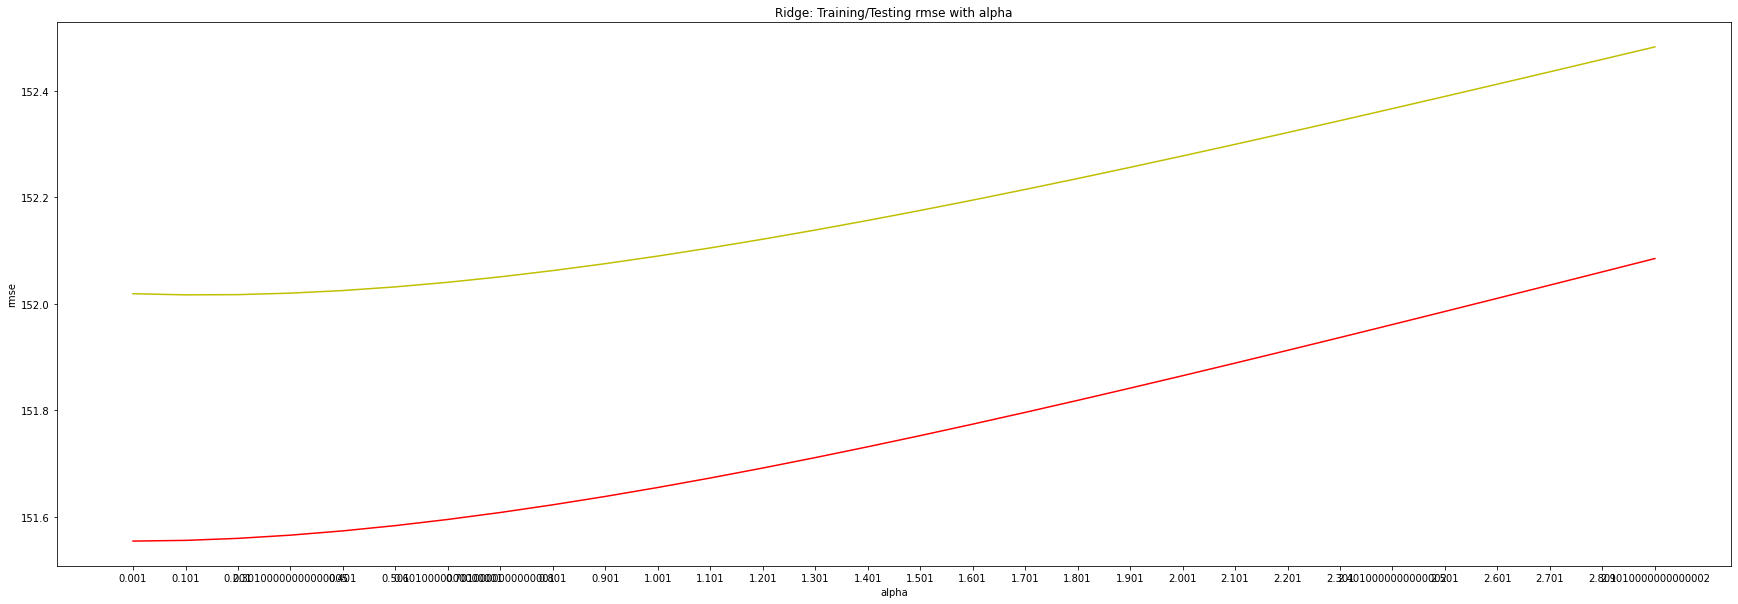

Optimal train alpha value:  0.001
Optimal train rmse:  151.55383578149304
Optimal test alpha value:  0.101
Optimal test rmse:  152.0168257664107


In [28]:
# whole data
apply_Ridge(x_train, y_train, x_test, y_test)

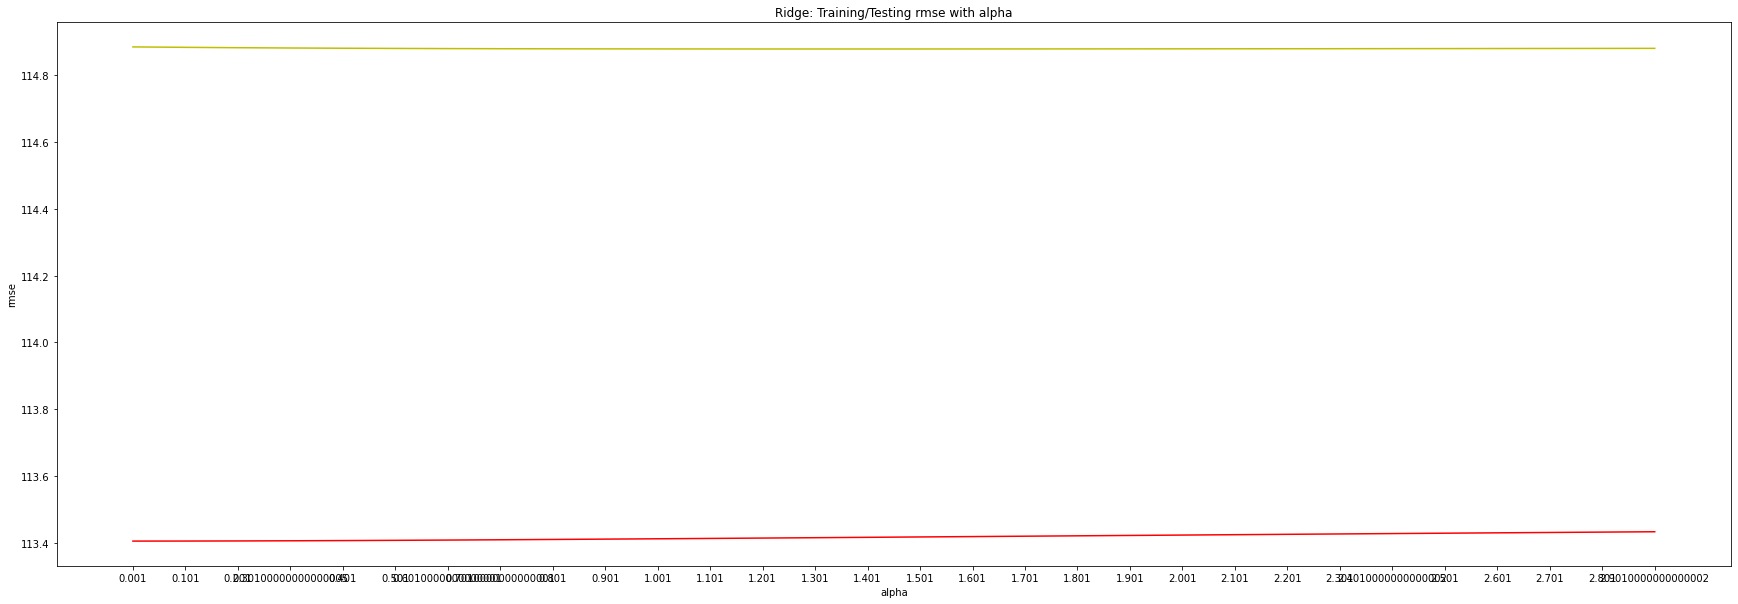

Optimal train alpha value:  0.001
Optimal train rmse:  113.40550305009548
Optimal test alpha value:  1.301
Optimal test rmse:  114.87831043559359


In [29]:
# day_time_data
apply_Ridge(day_x_train, day_y_train, day_x_test, day_y_test)

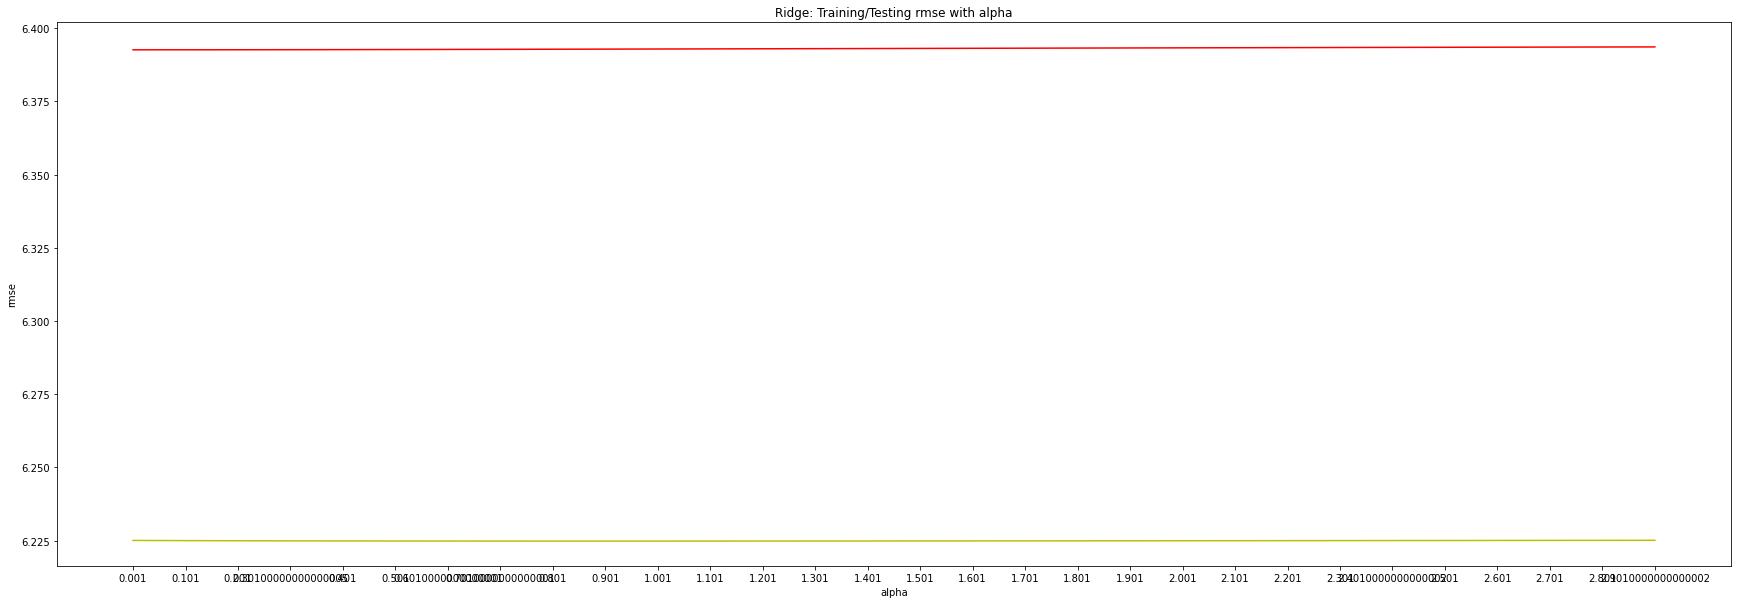

Optimal train alpha value:  0.001
Optimal train rmse:  6.3926241771098375
Optimal test alpha value:  0.901
Optimal test rmse:  6.2248161512794935


In [30]:
# night_time_data
apply_Ridge(night_x_train, night_y_train, night_x_test, night_y_test)

In [31]:
# combining day and night time results
day_ridge = Ridge(0.701)
day_ridge.fit(day_x_train, day_y_train)
night_ridge = Ridge(1.501)
night_ridge.fit(night_x_train, night_y_train)

day_y_train_pred = day_ridge.predict(day_x_train)
night_y_train_pred = night_ridge.predict(night_x_train)
train_rmse = combine_result(day_y_train, day_y_train_pred, night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

day_y_test_pred = day_ridge.predict(day_x_test)
night_y_test_pred = night_ridge.predict(night_x_test)
test_rmse = combine_result(day_y_test, day_y_test_pred, night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Train RMSE:  81.13739429551177
Test RMSE:  82.17835461406106


# Polynomial Regression

In [32]:
def apply_polynomial_regression(x_train, y_train, x_test, y_test, n):
  poly_reg = PolynomialFeatures(degree= n)
  poly_x_train = poly_reg.fit_transform(x_train) 
  poly_x_test = poly_reg.fit_transform(x_test)
  
  print(poly_x_train.shape)

  linear = LinearRegression()
  linear.fit(poly_x_train, y_train)

  print("n= ", n)
  y_train_pred = linear.predict(poly_x_train)
  train_rmse = metrics.mean_squared_error(y_train, y_train_pred) ** 0.5
  print("Train RMSE: ", train_rmse)
  y_test_pred = linear.predict(poly_x_test)
  test_rmse = metrics.mean_squared_error(y_test, y_test_pred) ** 0.5
  print("Test RMSE: ", test_rmse)

In [33]:
# whole data
for n in [2, 3, 4]:
  apply_polynomial_regression(x_train, y_train, x_test, y_test, n)

(41817, 136)
n=  2
Train RMSE:  78.94815875127165
Test RMSE:  79.76316347309206
(41817, 816)
n=  3
Train RMSE:  69.4886579999666
Test RMSE:  70.52791023793802
(41817, 3876)
n=  4
Train RMSE:  51.97700864293026
Test RMSE:  55.991477662151105


In [34]:
# day_time_data
for n in [2, 3, 4]:
  apply_polynomial_regression(day_x_train, day_y_train, day_x_test, day_y_test, n)

(21339, 120)
n=  2
Train RMSE:  105.7743335551083
Test RMSE:  107.38763474081033
(21339, 680)
n=  3
Train RMSE:  88.52632167289764
Test RMSE:  91.64781683677313
(21339, 3060)
n=  4
Train RMSE:  63.07592683607227
Test RMSE:  77.7846995811444


In [35]:
# night_time_data
for n in [2, 3, 4]:
  apply_polynomial_regression(night_x_train, night_y_train, night_x_test, night_y_test, n)

(20478, 120)
n=  2
Train RMSE:  5.629558596699495
Test RMSE:  5.547973314118362
(20478, 680)
n=  3
Train RMSE:  4.524679098715154
Test RMSE:  4.682002823672813
(20478, 3060)
n=  4
Train RMSE:  3.01223034291004
Test RMSE:  3.7496581410984495


In [36]:
# combining day and night time results
day_poly_reg = PolynomialFeatures(degree= 4)
poly_day_x_train = day_poly_reg.fit_transform(day_x_train) 
poly_day_x_test = day_poly_reg.fit_transform(day_x_test)

night_poly_reg = PolynomialFeatures(degree= 4)
poly_night_x_train = night_poly_reg.fit_transform(night_x_train) 
poly_night_x_test = night_poly_reg.fit_transform(night_x_test)

day_linear = LinearRegression()
day_linear.fit(poly_day_x_train, day_y_train)
night_linear = LinearRegression()
night_linear.fit(poly_night_x_train, night_y_train)

day_y_train_pred = day_linear.predict(poly_day_x_train)
night_y_train_pred = night_linear.predict(poly_night_x_train)
train_rmse = combine_result(day_y_train, day_y_train_pred, night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

day_y_test_pred = day_linear.predict(poly_day_x_test)
night_y_test_pred = night_linear.predict(poly_night_x_test)
test_rmse = combine_result(day_y_test, day_y_test_pred, night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Train RMSE:  45.107521105826294
Test RMSE:  55.626674792837434


# Feature Expansion

## Single Model (Without PCA)

In [37]:
def expand_features15(df, n):
  list_df=[]
  numpy_df=df.to_numpy()
  final_df=numpy_df

  for i in range(n):
    list_df.append(df.to_numpy())
    list_df[i][i+1:len(numpy_df),:]=numpy_df[:len(numpy_df)-(i+1),:]
    final_df=np.concatenate((final_df,list_df[i]),axis=1)
  
  list_names=["Month",	"Day"	,"Hour",	"Minute",	"Temperature",	"Cloud Type",	"Dew Point",	"Relative Humidity",	"Solar Zenith Angle",	"Surface Albedo",	"Pressure",	"Precipitable Water",	"Wind Direction",	"Wind Speed", "is_day"]
  for i in range(n):
    for j in range(15):
      list_names.append(list_names[j]+str(i))
  

  expanded_df = pd.DataFrame(final_df, columns = list_names)
  return expanded_df,list_names

In [38]:
def feature_expansion15_withoutPCA(feature_df,GHI,n):
  expanded_df, expanded_features_without=expand_features15(feature_df,n)
  print(expanded_df.shape)

  expanded_x_train, expanded_x_test, expanded_y_train, expanded_y_test = train_test_split(expanded_df, GHI, test_size=.20, random_state=42)

  print("Whole Dataset Model")
  apply_LR(expanded_x_train, expanded_y_train, expanded_x_test, expanded_y_test)

In [39]:
list_n=[1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,75,100]

for i in list_n:
  print(i)
  feature_expansion15_withoutPCA(feature_df,GHI,i)

1
(52272, 30)
Whole Dataset Model
Train RMSE:  145.75308716497506
Test RMSE:  147.68721941279728
2
(52272, 45)
Whole Dataset Model
Train RMSE:  143.21791047225625
Test RMSE:  144.505818193798
3
(52272, 60)
Whole Dataset Model
Train RMSE:  140.56062859212412
Test RMSE:  142.30291236998502
4
(52272, 75)
Whole Dataset Model
Train RMSE:  137.8637072437446
Test RMSE:  139.94232973925108
5
(52272, 90)
Whole Dataset Model
Train RMSE:  134.92882235811217
Test RMSE:  137.54002269057318
10
(52272, 165)
Whole Dataset Model
Train RMSE:  123.27374415251546
Test RMSE:  126.16610928195871
15
(52272, 240)
Whole Dataset Model
Train RMSE:  116.46664577351576
Test RMSE:  119.70866106720301
20
(52272, 315)
Whole Dataset Model
Train RMSE:  111.54917368964479
Test RMSE:  115.21302056390218
25
(52272, 390)
Whole Dataset Model
Train RMSE:  107.35595686467299
Test RMSE:  112.92460085017986
30
(52272, 465)
Whole Dataset Model
Train RMSE:  104.03066725402115
Test RMSE:  112.74345426457387
35
(52272, 540)
Whole D

## Day Night Model (Without PCA)

In [40]:
def expand_features(df, n):
  list_df=[]
  numpy_df=df.to_numpy()
  final_df=numpy_df

  for i in range(n):
    list_df.append(df.to_numpy())
    list_df[i][i+1:len(numpy_df),:]=numpy_df[:len(numpy_df)-(i+1),:]
    final_df=np.concatenate((final_df,list_df[i]),axis=1)
  
  list_names=["Month",	"Day"	,"Hour",	"Minute",	"Temperature",	"Cloud Type",	"Dew Point",	"Relative Humidity",	"Solar Zenith Angle",	"Surface Albedo",	"Pressure",	"Precipitable Water",	"Wind Direction",	"Wind Speed"]
  for i in range(n):
    for j in range(14):
      list_names.append(list_names[j]+str(i))
  

  expanded_df = pd.DataFrame(final_df, columns = list_names)
  return expanded_df,list_names

In [41]:
def feature_expansion_withoutPCA(day_feature_df,night_feature_df,day_GHI,night_GHI,n):
  expanded_day_df, expanded_features_without=expand_features(day_feature_df,n)
  expanded_night_df, expanded_features_without=expand_features(night_feature_df,n)
  print(expanded_day_df.shape)

  expanded_day_x_train, expanded_day_x_test, expanded_day_y_train, expanded_day_y_test = train_test_split(expanded_day_df, day_GHI, test_size=.20, random_state=42)
  expanded_night_x_train, expanded_night_x_test, expanded_night_y_train, expanded_night_y_test = train_test_split(expanded_night_df, night_GHI, test_size=.20, random_state=42)

  print("Day Time Model")
  apply_LR(expanded_day_x_train, expanded_day_y_train, expanded_day_x_test, expanded_day_y_test)

  print("Night Time Model")
  apply_LR(expanded_night_x_train, expanded_night_y_train, expanded_night_x_test, expanded_night_y_test)


  print("Combined Model")
  day_linear = LinearRegression()
  day_linear.fit(expanded_day_x_train, expanded_day_y_train)
  night_linear = LinearRegression()
  night_linear.fit(expanded_night_x_train, expanded_night_y_train)

  day_y_train_pred = day_linear.predict(expanded_day_x_train)
  night_y_train_pred = night_linear.predict(expanded_night_x_train)
  train_rmse = combine_result(expanded_day_y_train, day_y_train_pred, expanded_night_y_train, night_y_train_pred)
  print("Train RMSE: ", train_rmse)

  day_y_test_pred = day_linear.predict(expanded_day_x_test)
  night_y_test_pred = night_linear.predict(expanded_night_x_test)
  test_rmse = combine_result(expanded_day_y_test, day_y_test_pred, expanded_night_y_test, night_y_test_pred)
  print("Test RMSE: ", test_rmse)

In [42]:
list_n=[1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,75,100]

for i in list_n:
  print(i)
  feature_expansion_withoutPCA(day_feature_df,night_feature_df,day_GHI,night_GHI,i)

1
(26674, 28)
Day Time Model
Train RMSE:  113.1911480707158
Test RMSE:  114.93920406393704
Night Time Model
Train RMSE:  6.121855381358566
Test RMSE:  5.986153348395325
Combined Model
Train RMSE:  80.97142003607642
Test RMSE:  82.21250956938489
2
(26674, 42)
Day Time Model
Train RMSE:  113.00755204578685
Test RMSE:  115.0026626214298
Night Time Model
Train RMSE:  6.013043563335241
Test RMSE:  5.9539256418023045
Combined Model
Train RMSE:  80.83645290300272
Test RMSE:  82.25663626857363
3
(26674, 56)
Day Time Model
Train RMSE:  112.87107223647936
Test RMSE:  114.84560289139245
Night Time Model
Train RMSE:  5.959605682948458
Test RMSE:  5.889975440660579
Combined Model
Train RMSE:  80.73715070355944
Test RMSE:  82.1423286123892
4
(26674, 70)
Day Time Model
Train RMSE:  112.75862335096964
Test RMSE:  114.70365984215421
Night Time Model
Train RMSE:  5.925756698605809
Test RMSE:  5.8476682818682795
Combined Model
Train RMSE:  80.65570896526017
Test RMSE:  82.03957873272591
5
(26674, 84)
Day

## With PCA (Day Night)

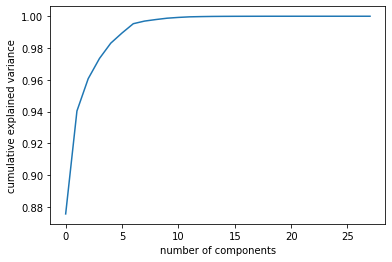

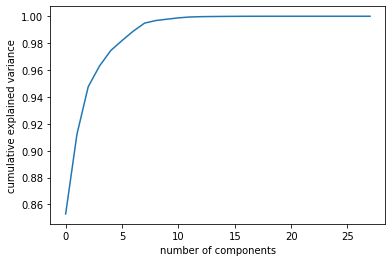

In [43]:
expanded_day_df, expanded_features_without=expand_features(day_feature_df,1)
expanded_night_df, expanded_features_without=expand_features(night_feature_df,1)

day_pca = PCA().fit(expanded_day_df)
plt.plot(np.cumsum(day_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

night_pca = PCA().fit(expanded_night_df)
plt.plot(np.cumsum(night_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [44]:
num_features = 7

day_num_features=num_features

day_pca = PCA(n_components=day_num_features)
day_pca_feature_df = day_pca.fit_transform(expanded_day_df)
# print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(day_pca.explained_variance_ratio_))*100, 2))

night_num_features=num_features
night_pca = PCA(n_components=night_num_features)
night_pca_feature_df = night_pca.fit_transform(expanded_night_df)
# print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(night_pca.explained_variance_ratio_))*100, 2))

list_names_pca=[]
for i in range(num_features):
  list_names_pca.append("pca_component"+str(i+1))


 Total Variance Explained: 99.53

 Total Variance Explained: 98.89


In [45]:
day_pca_feature_dataframe=pd.DataFrame(day_pca_feature_df,columns=list_names_pca)
night_pca_feature_dataframe=pd.DataFrame(night_pca_feature_df,columns=list_names_pca)
expanded_day_x_train, expanded_day_x_test, expanded_day_y_train, expanded_day_y_test = train_test_split(day_pca_feature_dataframe, day_GHI, test_size=.20, random_state=42)
expanded_night_x_train, expanded_night_x_test, expanded_night_y_train, expanded_night_y_test = train_test_split(night_pca_feature_dataframe, night_GHI, test_size=.20, random_state=42)

print("Combined Model")
day_linear = LinearRegression()
day_linear.fit(expanded_day_x_train, expanded_day_y_train)
night_linear = LinearRegression()
night_linear.fit(expanded_night_x_train, expanded_night_y_train)

day_y_train_pred = day_linear.predict(expanded_day_x_train)
night_y_train_pred = night_linear.predict(expanded_night_x_train)
train_rmse = combine_result(expanded_day_y_train, day_y_train_pred, expanded_night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

day_y_test_pred = day_linear.predict(expanded_day_x_test)
night_y_test_pred = night_linear.predict(expanded_night_x_test)
test_rmse = combine_result(expanded_day_y_test, day_y_test_pred, expanded_night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Combined Model
Train RMSE:  82.90040019950882
Test RMSE:  83.83931492391936


In [46]:
day_pca_feature_dataframe=pd.DataFrame(day_pca_feature_df,columns=list_names_pca)

night_pca_feature_dataframe=pd.DataFrame(night_pca_feature_df,columns=list_names_pca)

expanded_day_x_train, expanded_day_x_test, expanded_day_y_train, expanded_day_y_test = train_test_split(day_pca_feature_dataframe, day_GHI, test_size=.20, random_state=42)
expanded_night_x_train, expanded_night_x_test, expanded_night_y_train, expanded_night_y_test = train_test_split(night_pca_feature_dataframe, night_GHI, test_size=.20, random_state=42)

apply_LR(expanded_day_x_train, expanded_day_y_train, expanded_day_x_test, expanded_day_y_test)
apply_LR(expanded_night_x_train, expanded_night_y_train, expanded_night_x_test, expanded_night_y_test)

Train RMSE:  115.8801359798128
Test RMSE:  117.20687292609013
Train RMSE:  6.4117349624838305
Test RMSE:  6.237719792444703


In [47]:
print("Combined Model")
day_linear = LinearRegression()
day_linear.fit(expanded_day_x_train, expanded_day_y_train)
night_linear = LinearRegression()
night_linear.fit(expanded_night_x_train, expanded_night_y_train)

day_y_train_pred = day_linear.predict(expanded_day_x_train)
night_y_train_pred = night_linear.predict(expanded_night_x_train)
train_rmse = combine_result(expanded_day_y_train, day_y_train_pred, expanded_night_y_train, night_y_train_pred)
print("Train RMSE: ", train_rmse)

day_y_test_pred = day_linear.predict(expanded_day_x_test)
night_y_test_pred = night_linear.predict(expanded_night_x_test)
test_rmse = combine_result(expanded_day_y_test, day_y_test_pred, expanded_night_y_test, night_y_test_pred)
print("Test RMSE: ", test_rmse)

Combined Model
Train RMSE:  82.90040019950882
Test RMSE:  83.83931492391936


# With PCA (Single)

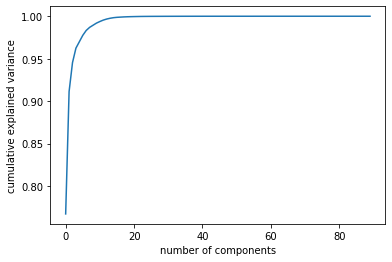

In [48]:
expanded_df, expanded_features_without=expand_features15(feature_df,5)

pca = PCA().fit(expanded_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [49]:
num_features = 15

pca = PCA(n_components=num_features)
pca_feature_df = pca.fit_transform(expanded_df)
# print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

list_names_pca=[]
for i in range(num_features):
  list_names_pca.append("pca_component"+str(i+1))


 Total Variance Explained: 99.83


In [50]:
pca_feature_dataframe=pd.DataFrame(pca_feature_df, columns=list_names_pca)
expanded_x_train, expanded_x_test, expanded_y_train, expanded_y_test = train_test_split(pca_feature_dataframe, GHI, test_size=.20, random_state=42)

print("Whole Dataset Model")
apply_LR(expanded_x_train, expanded_y_train, expanded_x_test, expanded_y_test)

Whole Dataset Model
Train RMSE:  161.53142967454795
Test RMSE:  161.5475791923635
